In [1]:
import os
import numpy as np
import pandas as pd
import yaml
import bayes_opt
from scipy.stats import norm
from plotly.subplots import make_subplots
from chspy import CubicHermiteSpline
from bayes_opt import BayesianOptimization
from bayes_opt.util import load_logs
from bayes_opt.event import Events
from bayes_opt.logger import JSONLogger
from scipy.optimize import NonlinearConstraint
import matplotlib.pyplot as plt
import seaborn as sns


# Define the path for saving/loading optimization progress
SAVE_PATH = "/Users/nathanirniger/Desktop/Bayes/bayesian_optimization_progress_y.json"

# Track scores for real-time visualization
score_history = []


In [2]:

def plot_scores():
    plt.figure(figsize=(10, 6))
    plt.plot(score_history, label="Score History")
    plt.xlabel("Iteration")
    plt.ylabel("Score")
    plt.title("Optimization Score Trend")
    plt.legend()
    plt.show()

In [3]:
def easy_score(force2_start_time, force2_end_time):

    force2_start_time_target = 0.2
    force2_end_time_target = 0.7

    # score = np.abs(force1_end_time - force1_end_time_target) + np.abs(force1_peak_force - force1_peak_force_target) + np.abs(force2_start_time - force2_start_time_target) + np.abs(force2_peak_time - force2_peak_time_target) + np.abs(force2_peak_force - force2_peak_force_target) + np.abs(force2_end_time - force2_end_time_target)
    score = (force2_start_time - force2_start_time_target)**2 + (force2_end_time - force2_end_time_target)**2
    return -score

In [4]:
def objective(force2_start_time, force2_end_time):

    score = easy_score(force2_start_time, force2_end_time)

    # Log scores for visualization
    score_history.append(score)
    # Log results

    return score

In [5]:
pbounds = {
    "force2_start_time": (0.0, 1.0),      # Start time for force2
    "force2_end_time": (0.0, 1.0)         # End time for force2
}


def load_optimizer(kappa):
    # constraint = NonlinearConstraint(constraint_func, lb=-1, ub=0)
    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=pbounds,                   # Parameter bounds
        acquisition_function=acquisition,  # Acquisition function: Upper Confidence Bound
        # constraint=constraint,             # Constraint
        random_state=1,                    # Random seed accepts integer value and is used for reproducibility.
        verbose=2                          # Verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    )
    
    if os.path.exists(SAVE_PATH):
        load_logs(optimizer, logs=[SAVE_PATH])
        print("Loaded optimization progress from file.")
    else:
        print("No saved progress found. Starting a new optimization.")
        
    return optimizer

# Save progress using a JSONLogger
def save_progress(optimizer):
    logger = JSONLogger(path=SAVE_PATH)
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)


def explorate(optimizer, init_points=10, n_iter=0):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )

def optimize(optimizer, init_points=0, n_iter=1):
    optimizer.maximize(
        init_points=init_points,  # Number of random initial points
        n_iter=n_iter,            # Number of optimization iterations
    )


No saved progress found. Starting a new optimization.
(array([-0.55096186]), array([0.02530612]))
(array([-0.54174526]), array([0.02002941]))
(array([-0.54199226]), array([0.01972605]))
(array([-0.54218969]), array([0.01953992]))
(array([-0.53966601]), array([0.01794853]))
(array([-0.53661444]), array([0.01635828]))
(array([-0.53403277]), array([0.01502586]))
(array([-0.53249959]), array([0.0138553]))
(array([-0.53110672]), array([0.01294459]))
(array([-0.53003063]), array([0.01218383]))
(array([-0.5295059]), array([0.01180808]))
(array([-0.52948643]), array([0.01169673]))
(array([-0.52971639]), array([0.01172709]))
(array([-0.53000266]), array([0.01178102]))
(array([-0.53030505]), array([0.01183497]))
(array([-0.53064111]), array([0.01190356]))
(array([-0.53098266]), array([0.01196894]))
(array([-0.53135739]), array([0.0120498]))
(array([-0.53161161]), array([0.01205974]))
(array([-0.53199077]), array([0.01213707]))
(array([-0.5323765]), array([0.01221621]))
(array([-0.53272188]), arr

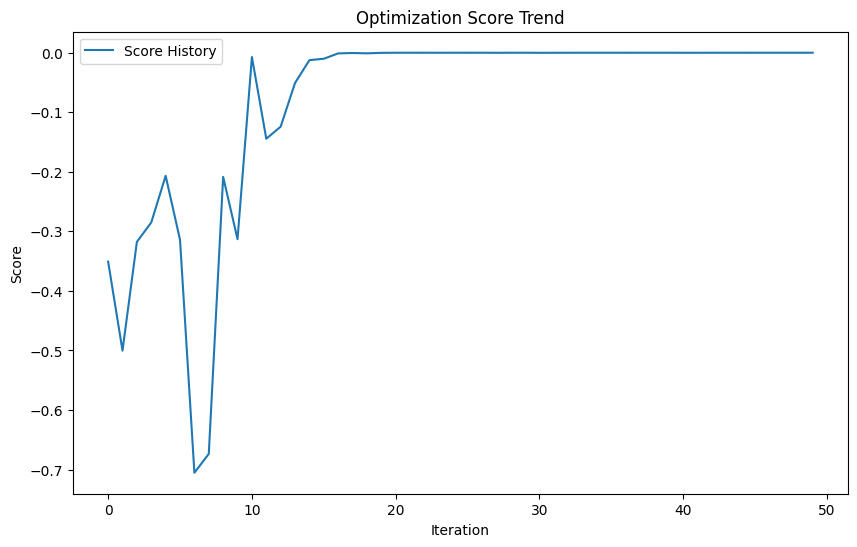

In [6]:
optimizer = load_optimizer(kappa=2.5)
save_progress(optimizer)

# Run initial exploration
explorate(optimizer)

# Run optimization
for i in range(40):
    optimize(optimizer)
    print(optimizer._gp.predict([[0.2, 0.7]], return_std=True))

# Output the best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best score:", optimizer.max["target"])

# Plot the optimization score trend
plot_scores()

In [ ]:

import plotly.graph_objects as go
from plotly.offline import iplot

def visualize_objective_surface_interactive(optimizer):
    # Use a 2D slice for simplicity (vary two parameters, fix others)
    x = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    y = np.linspace(0.0, 1.0, 50)  # Adjust these ranges to match pbounds
    X, Y = np.meshgrid(x, y)

    # Fixed parameters for visualization

    # Compute objective values for each combination of x, y
    Z = np.array([
        objective(x, y)
        for xi, yi in zip(np.ravel(X), np.ravel(Y))
    ])
    Z = Z.reshape(X.shape)

    # Extract evaluated points and hover information from optimizer.res
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params["force2_start_time"])
        evaluated_y.append(params["force2_end_time"])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time']:.2f}"
        )
        hover_texts.append(hover_text)

    # Extract the best point
    best_params = optimizer.max["params"]
    best_x = best_params["force2_start_time"]
    best_y = best_params["force2_end_time"]
    best_score = optimizer.max["target"]

    # Create the interactive plot
    fig = go.Figure()

    # Add the contour surface
    fig.add_trace(go.Contour(
        x=x, y=y, z=Z,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.12,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Objective Surface"
    ))

    # Add evaluated points with hover information
    fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Score",
                titleside="right",
                x=1.05,  # Move colorbar slightly right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add hover information
        hoverinfo="text",  # Display custom hover text
        name="Evaluated Points"
    ))

    # Add the best point
    fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the target point
    fig.add_trace(go.Scatter(
        x=[0.2], y=[0.7],
        mode='markers',
        marker=dict(
            size=15,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='gold')
        ),
        name=f"Target Value",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Update layout for better visualization
    fig.update_layout(
        title="Interactive Objective Function Surface",
        xaxis_title="force2_start_time",
        yaxis_title="force2_peak_time",
        xaxis=dict(scaleanchor="y"),  # Link x-axis scale to y-axis scale
        yaxis=dict(scaleanchor="x"),  # Link y-axis scale to x-axis scale
        legend=dict(yanchor="top", y=0.9, xanchor="left", x=0.01),
        template="plotly"
    )

    # Show the interactive plot
    iplot(fig)


# Example usage:
visualize_objective_surface_interactive(optimizer)


In [11]:
optimizer.acquisition_function._fit_gp(optimizer._gp, optimizer._space)

In [12]:


import numpy as np
import plotly.graph_objects as go
from plotly.offline import iplot

def interactive_score_and_std_surface(optimizer, param_x, param_y, pbounds):
    # Fixed target values for other parameters
    force2_end_time_target = 0.7
    force2_start_time_target = 0.2


    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))

    # Populate grid with scores from the GP model
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            curr_score, curr_std = optimizer._gp.predict(
                [[x, y]], 
                # [[x, force2_peak_time_target, force2_peak_force_target, y]],
                return_std=True
            )
            scores[i, j] = curr_score.item()
            stds[i, j] = curr_std.item()

    # Extract evaluated points from optimizer
    evaluated_x = []
    evaluated_y = []
    evaluated_scores = []
    hover_texts = []

    for res in optimizer.res:
        params = res["params"]
        score = res["target"]

        evaluated_x.append(params[param_x])
        evaluated_y.append(params[param_y])
        evaluated_scores.append(score)

        # Format hover text to include all parameter values and the score
        hover_text = (
            f"<b>Score:</b> {score:.2f}<br>"
            f"<b>force2_start_time:</b> {params['force2_start_time']:.2f}<br>"
            f"<b>force2_end_time:</b> {params['force2_end_time']:.2f}"
        )
        hover_texts.append(hover_text)

    # Get the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Interactive score surface plot
    score_fig = go.Figure()

    # Add score surface
    score_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=scores.T,
        colorscale="Viridis",
        colorbar=dict(
            title="Score",
            titleside="right",
            x=1.0,  # Move colorbar slightly right
            len=0.8  # Adjust colorbar length
        ),
        contours=dict(showlabels=True),
        name="Score Surface"
    ))

    # Add evaluated points with hover information
    score_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color=evaluated_scores,
            colorscale="Cividis",
            showscale=True,
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.12,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
        ),
        text=hover_texts,  # Add detailed hover information
        hoverinfo="text",
        name="Evaluated Points"
    ))

    # Add the best point (star)
    score_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    score_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    score_fig.update_layout(
        title="Interactive Score Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),  # Adjust legend position
        template="plotly"
    )

    iplot(score_fig)


    # Interactive standard deviation surface plot
    std_fig = go.Figure()

    # Add standard deviation surface
    std_fig.add_trace(go.Contour(
        x=x_vals, y=y_vals, z=stds.T,
        colorscale="Viridis",
        colorbar=dict(title="Standard Deviation"),
        contours=dict(showlabels=True),
        name="Standard Deviation Surface"
    ))

    # Add evaluated points
    std_fig.add_trace(go.Scatter(
        x=evaluated_x, y=evaluated_y,
        mode='markers',
        marker=dict(
            size=8,
            color="red",
            symbol="circle",
            line=dict(width=1, color="black")
        ),
        text=hover_texts,  # Reuse hover information with additional parameters
        hoverinfo="text",
        name="Evaluated Points"
    ))
    
    # Add the best point (star)
    std_fig.add_trace(go.Scatter(
        x=[best_x], y=[best_y],
        mode='markers',
        marker=dict(
            size=15,
            color='red',
            symbol='star',
            line=dict(width=2, color='gold')
        ),
        name=f"Best Value (Score: {best_score:.2f})",
        hoverinfo="skip"  # Skip hover text for the best point
    ))

    # Add the actual target values (circle)
    std_fig.add_trace(go.Scatter(
        x=[force2_start_time_target], y=[force2_end_time_target],
        mode='markers',
        marker=dict(
            size=12,
            color='blue',
            symbol='circle',
            line=dict(width=2, color='black')
        ),
        name="Target Values",
        text=f"<b>Target</b><br>{param_x}: {force2_start_time_target}<br>{param_y}: {force2_end_time_target}",
        hoverinfo="text"
    ))

    std_fig.update_layout(
        title="Interactive Standard Deviation Surface",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template="plotly"
    )

    iplot(std_fig)

    # save the plot
    score_fig.write_html(f"/Users/nathanirniger/Desktop/plots/score_fig_{param_x}_{param_y}.html")

# Example usage:
interactive_score_and_std_surface(optimizer, 'force2_start_time', 'force2_end_time', pbounds)



In [ ]:
def visualize_score_and_acquisition_with_targets(optimizer):
    param_x = 'force2_start_time'
    param_y = 'force2_end_time'

    # Define the target values
    force2_start_time_target = 0.2
    force2_end_time_target = 0.7

    kappa = 2.5  # Exploration parameter for the acquisition function

    acquisition = bayes_opt.acquisition.UpperConfidenceBound(kappa=kappa)

    # Generate a grid for two parameters
    x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
    y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
    scores = np.zeros((len(x_vals), len(y_vals)))
    stds = np.zeros((len(x_vals), len(y_vals)))
    acquisition_values = np.zeros((len(x_vals), len(y_vals)))

    # Populate grid with GP predictions and acquisition function values
    for i, x in enumerate(x_vals):
        for j, y in enumerate(y_vals):
            # Predict the score and standard deviation
            curr_score, curr_std = optimizer._gp.predict(
            [[x, y]], 
            return_std=True)
            scores[j, i] = curr_score.item()
            stds[j, i] = curr_std.item()

    xx, yy = np.meshgrid(x_vals, y_vals)
    grid_points = np.c_[xx.ravel(), yy.ravel()]  # Shape (n_samples, 2)

    acquisition_values = -1 * acquisition._get_acq(gp=optimizer._gp)(grid_points)
    acquisition_values = acquisition_values.reshape(xx.shape)

    # scores, stds = optimizer._gp.predict(grid_points, return_std=True)
    # scores = scores.reshape(xx.shape)
    # stds = stds.reshape(xx.shape)

    # Extract evaluated points
    evaluated_x = [res["params"][param_x] for res in optimizer.res]
    evaluated_y = [res["params"][param_y] for res in optimizer.res]
    evaluated_scores = [res["target"] for res in optimizer.res]

    # Extract the best point
    best_params = optimizer.max["params"]
    best_x = best_params[param_x]
    best_y = best_params[param_y]
    best_score = optimizer.max["target"]

    # Create the interactive plot for score surface
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Score Surface", "Acquisition Function"))

    # Add the score surface
    fig.add_trace(
        go.Contour(
            x=x_vals, y=y_vals, z=scores,
            colorscale="Viridis",
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=0.45,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
            contours=dict(showlabels=True),
        ),
        row=1, col=1
    )

    # Add evaluated points to the score surface
    fig.add_trace(
        go.Scatter(
            x=evaluated_x, y=evaluated_y,
            mode='markers',
            marker=dict(
                size=8,
                color=evaluated_scores,
                colorscale="Cividis",
                showscale=False
            ),
            name="Evaluated Points"
        ),
        row=1, col=1
    )

    # Add the best point to the score surface
    fig.add_trace(
        go.Scatter(
            x=[best_x], y=[best_y],
            mode='markers',
            marker=dict(
                size=15,
                color='red',
                symbol='star',
                line=dict(width=2, color='gold')
            ),
            name=f"Best Value (Score: {best_score:.2f})"
        ),
        row=1, col=1
    )

    # Add the target point to the score surface
    fig.add_trace(
        go.Scatter(
            x=[force2_start_time_target], y=[force2_end_time_target],
            mode='markers',
            marker=dict(
                size=10,
                color='blue',
                symbol='circle',
                line=dict(width=2, color='black')
            ),
            name="Target Values"
        ),
        row=1, col=1
    )

    # Add the acquisition function surface
    fig.add_trace(
        go.Contour(
            x=x_vals, y=y_vals, z=acquisition_values.T,
            colorscale="Plasma",
            colorbar=dict(
                title="Evaluated Score",
                titleside="right",
                x=1.0,  # Move evaluated points colorbar further right
                len=0.8  # Adjust colorbar length
            ),
            contours=dict(showlabels=True),
        ),
        row=1, col=2
    )

    # Add evaluated points to the acquisition function surface
    fig.add_trace(
        go.Scatter(
            x=evaluated_x, y=evaluated_y,
            mode='markers',
            marker=dict(
                size=8,
                color=evaluated_scores,
                colorscale="Cividis",
                showscale=False
            ),
            name="Evaluated Points"
        ),
        row=1, col=2
    )

    # Update layout for square appearance in the acquisition function plot
    fig.update_layout(
        title="Interactive Score and Acquisition Function Surfaces",
        xaxis_title=param_x,
        yaxis_title=param_y,
        xaxis=dict(scaleanchor="y"),
        yaxis=dict(scaleanchor="x"),
        template="plotly",
        legend=dict(yanchor="top", y=1.3, xanchor="left", x=0.4),
        showlegend=True,
    )

    # Show the plot
    iplot(fig)

# Example usage:
visualize_score_and_acquisition_with_targets(optimizer)


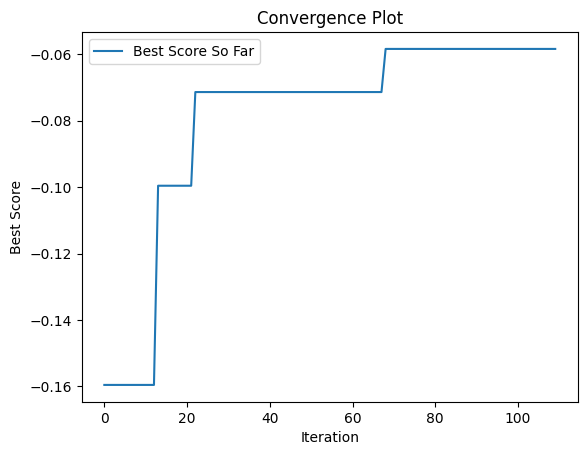

In [121]:
best_scores = [max([res["target"] for res in optimizer.res[:i+1]]) for i in range(len(optimizer.res))]

plt.plot(best_scores, label='Best Score So Far')
plt.xlabel('Iteration')
plt.ylabel('Best Score')
plt.title('Convergence Plot')
plt.legend()
plt.show()


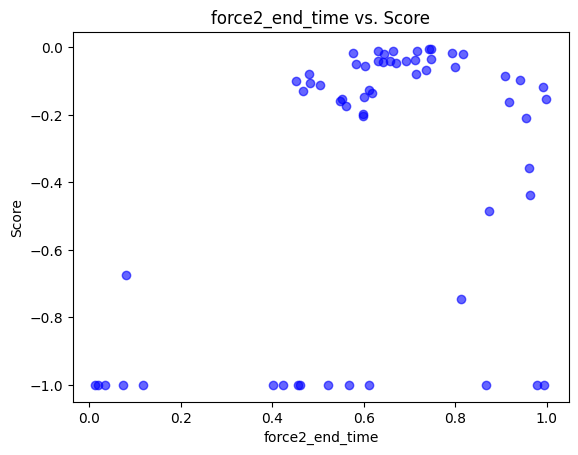

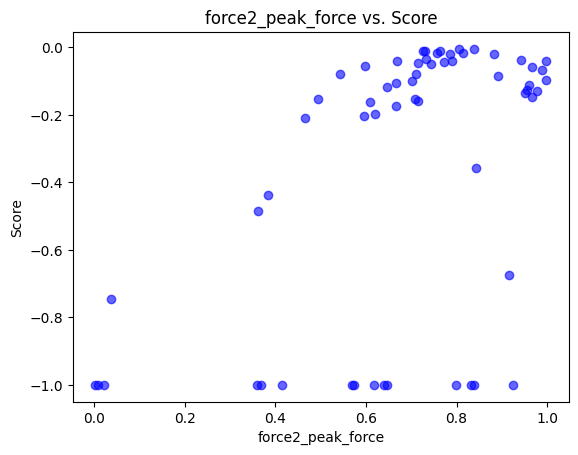

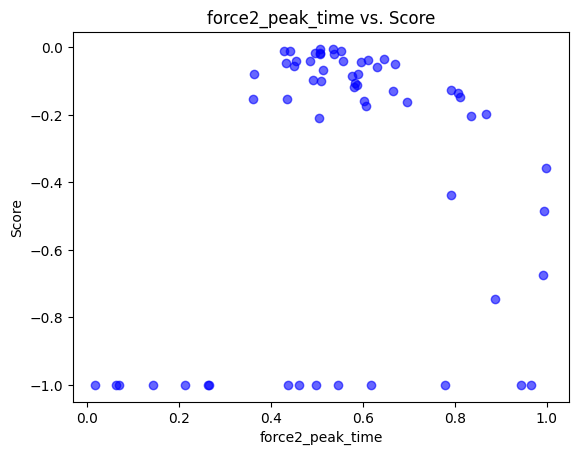

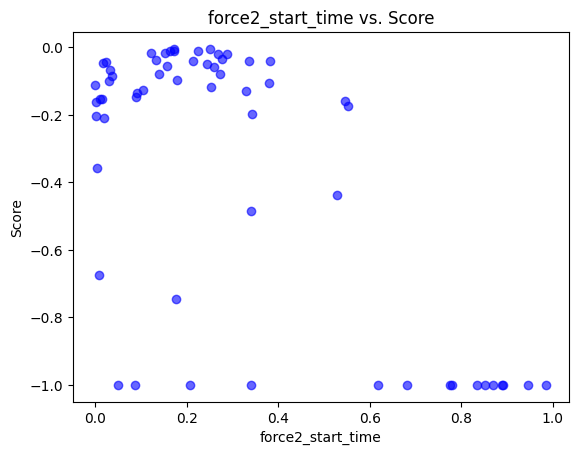

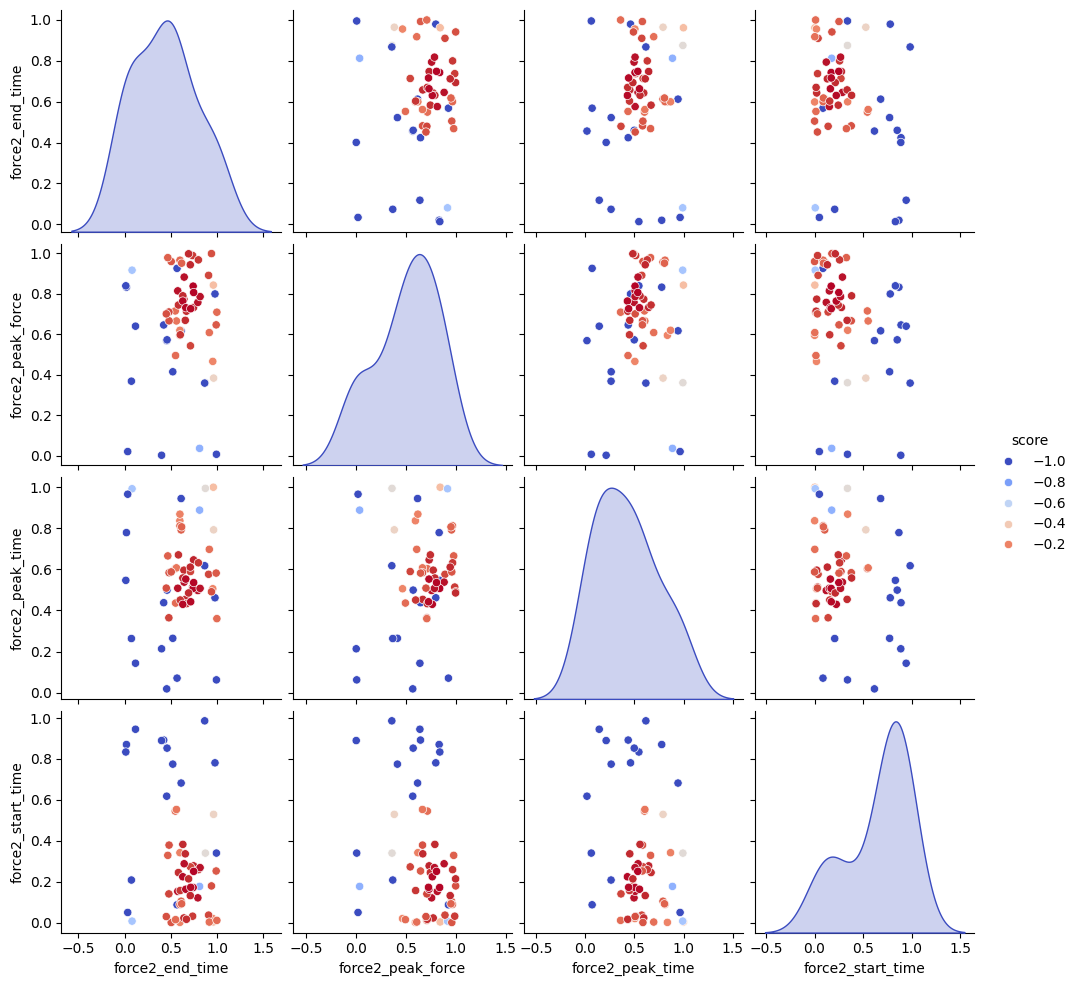

In [29]:
# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame([res['params'] | {'score': res['target']} for res in optimizer.res])

# 1D parameter vs. score plots
for param in results_df.columns[:-1]:  # Exclude score
    plt.figure()
    plt.scatter(results_df[param], results_df['score'], c='blue', alpha=0.6)
    plt.xlabel(param)
    plt.ylabel('Score')
    plt.title(f'{param} vs. Score')
    plt.show()

# 2D pair plots for selected parameters
sns.pairplot(results_df, vars=results_df.columns[:-1], hue='score', palette="coolwarm", diag_kind="kde")
plt.show()

In [22]:


# Example with two parameters
x_vals = np.linspace(pbounds[param_x][0], pbounds[param_x][1], 50)
y_vals = np.linspace(pbounds[param_y][0], pbounds[param_y][1], 50)
acq_values = np.zeros((len(x_vals), len(y_vals)))

for i, x in enumerate(x_vals):
    for j, y in enumerate(y_vals):
        acq_values[i, j] = optimizer.acq_func.utility([[x, y]], optimizer._gp, 0)

plt.imshow(acq_values, extent=(x_vals[0], x_vals[-1], y_vals[0], y_vals[-1]), origin='lower', cmap='hot', aspect='auto')
plt.colorbar(label='Acquisition Value')
plt.xlabel(param_x)
plt.ylabel(param_y)
plt.title('Acquisition Function Landscape')
plt.show()


KeyboardInterrupt: 